# Notebook 02 — Stabilizer Subgroup and Mutual Exclusion

This notebook verifies **Claim 2**: mutual exclusion corresponds to restricting the admissible scheduling space to a stabilizer subgroup of `S_n`.

---

**Claim 2 (formal):**  
Let `x ∈ P` represent a critical resource slot. The set of mutex-admissible schedules is:

```
Stab(x) = { σ ∈ S_n | σ(x) = x }
```

This is a subgroup of `S_n` of order `(n-1)!`, isomorphic to `S_{n-1}`.

## Setup

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.path.dirname('__file__'), '..', 'src'))

import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

from permutations import (
    generate_Sn,
    identity,
    cycle_notation_str,
    is_subgroup,
)
from stabilizer import (
    compute_stabilizer,
    compute_orbit,
    coset_decomposition,
    verify_stabilizer,
    print_cosets,
)

---
## 1. Computing Stab(x) for S_3

Start with `n = 3`, fix `x = 1`. We filter `S_3` for all permutations satisfying `σ(1) = 1`.

In [2]:
n  = 3
x  = 1
S3 = generate_Sn(n)

stab = compute_stabilizer(S3, fixed_point=x)

print(f"S_3 ({len(S3)} elements):")
for sigma in S3:
    in_stab = sigma[x] == x
    marker  = "  ← σ(1) = 1  [in Stab(1)]" if in_stab else f"  ← σ(1) = {sigma[x]}"
    print(f"  {cycle_notation_str(sigma):<15} {marker}")

print(f"\n|Stab(1)| = {len(stab)}  (expected (3-1)! = {math.factorial(n-1)})")

S_3 (6 elements):
  e                 ← σ(1) = 1  [in Stab(1)]
  (2 3)             ← σ(1) = 1  [in Stab(1)]
  (1 2)             ← σ(1) = 2
  (1 2 3)           ← σ(1) = 2
  (1 3 2)           ← σ(1) = 3
  (1 3)             ← σ(1) = 3

|Stab(1)| = 2  (expected (3-1)! = 2)


---
## 2. Verifying Stab(x) is a Subgroup

Check all three subgroup axioms: identity, closure, inverses.

In [3]:
print("Subgroup axiom check for Stab(1) in S_3:\n")
result = is_subgroup(stab, n)
print(f"\nStab(1) is a subgroup: {'✓' if result else '✗'}")

Subgroup axiom check for Stab(1) in S_3:


Stab(1) is a subgroup: ✓


---
## 3. Orbit-Stabilizer Theorem

Verify: `|S_n| = |Orb(x)| × |Stab(x)|`

In [4]:
print(f"{'n':<5} {'|S_n|':<8} {'|Orb(x)|':<12} {'|Stab(x)|':<12} {'Product':<10} {'Check'}")
print("-" * 55)

for n in range(2, 7):
    Sn   = generate_Sn(n)
    stab = compute_stabilizer(Sn, fixed_point=1)
    orb  = compute_orbit(Sn, point=1)
    prod = len(orb) * len(stab)
    ok   = "✓" if prod == len(Sn) else "✗"
    print(f"{n:<5} {len(Sn):<8} {len(orb):<12} {len(stab):<12} {prod:<10} {ok}")

n     |S_n|    |Orb(x)|     |Stab(x)|    Product    Check
-------------------------------------------------------
2     2        2            1            2          ✓
3     6        3            2            6          ✓
4     24       4            6            24         ✓
5     120      5            24           120        ✓
6     720      6            120          720        ✓


---
## 4. Coset Decomposition — Visualizing Mutex Violations

The coset decomposition of `S_n` by `Stab(x)` partitions the scheduling space into:
- **One admissible coset** — the stabilizer itself (mutex respected)
- **n-1 violation cosets** — each corresponding to a different process illegally occupying the critical slot

In [5]:
print_cosets(n=3, fixed_point=1)
print()
print_cosets(n=4, fixed_point=1)


Coset decomposition of S_3 by Stab(1):

  Stab(1)       ← admissible (mutex respected)
    { e,  (2 3) }

  coset 1  ← VIOLATION: process 2 in slot 1
    { (1 2),  (1 2 3) }

  coset 2  ← VIOLATION: process 3 in slot 1
    { (1 3 2),  (1 3) }



Coset decomposition of S_4 by Stab(1):

  Stab(1)       ← admissible (mutex respected)
    { e,  (3 4),  (2 3),  (2 3 4),  (2 4 3),  (2 4) }

  coset 1  ← VIOLATION: process 2 in slot 1
    { (1 2),  (1 2)(3 4),  (1 2 3),  (1 2 3 4),  (1 2 4 3),  (1 2 4) }

  coset 2  ← VIOLATION: process 3 in slot 1
    { (1 3 2),  (1 3 4 2),  (1 3),  (1 3 4),  (1 3)(2 4),  (1 3 2 4) }

  coset 3  ← VIOLATION: process 4 in slot 1
    { (1 4 3 2),  (1 4 2),  (1 4 3),  (1 4),  (1 4 2 3),  (1 4)(2 3) }



---
## 5. Visualizing the Coset Structure

A bar chart showing how `S_n` is partitioned into `n` equal cosets of size `(n-1)!`.

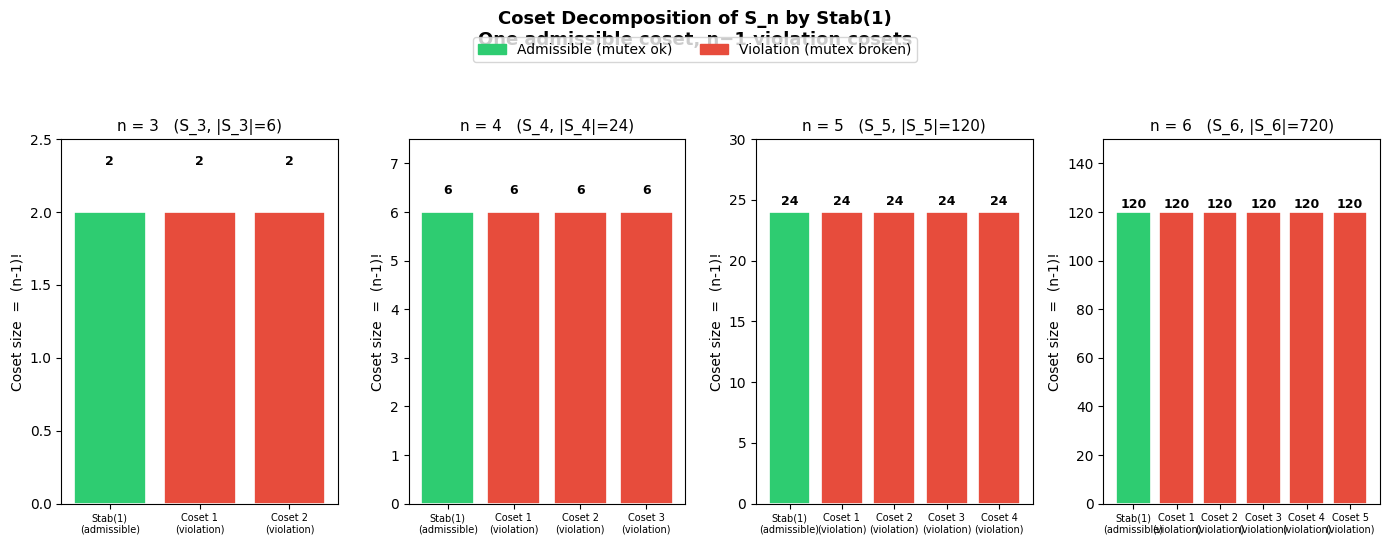

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(14, 5))

colors = ['#2ecc71'] + ['#e74c3c'] * 10   # green = admissible, red = violation

for ax, n in zip(axes, range(3, 7)):
    Sn     = generate_Sn(n)
    stab   = compute_stabilizer(Sn, fixed_point=1)
    cosets = coset_decomposition(Sn, stab)

    labels = ['Stab(1)\n(admissible)'] + [f'Coset {i}\n(violation)' for i in range(1, n)]
    sizes  = [len(c) for c in cosets]
    clrs   = [colors[i] for i in range(len(cosets))]

    bars = ax.bar(labels, sizes, color=clrs, edgecolor='white', linewidth=1.2)
    ax.set_title(f'n = {n}   (S_{n}, |S_{n}|={math.factorial(n)})', fontsize=11)
    ax.set_ylabel('Coset size  =  (n-1)!')
    ax.set_ylim(0, max(sizes) * 1.25)
    ax.tick_params(axis='x', labelsize=7)

    for bar, size in zip(bars, sizes):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                str(size), ha='center', va='bottom', fontsize=9, fontweight='bold')

admissible_patch = mpatches.Patch(color='#2ecc71', label='Admissible (mutex ok)')
violation_patch  = mpatches.Patch(color='#e74c3c', label='Violation (mutex broken)')
fig.legend(handles=[admissible_patch, violation_patch],
           loc='upper center', ncol=2, fontsize=10, bbox_to_anchor=(0.5, 1.04))

plt.suptitle('Coset Decomposition of S_n by Stab(1)\n'
             'One admissible coset, n−1 violation cosets',
             fontsize=13, fontweight='bold', y=1.08)
plt.tight_layout()
plt.savefig('../notebooks/coset_decomposition.png', dpi=120, bbox_inches='tight')
plt.show()

---
## 6. |Stab(x)| as a Fraction of |S_n|

How much of the scheduling space is mutex-admissible?

In [7]:
ns          = list(range(2, 8))
fractions   = [math.factorial(n-1) / math.factorial(n) for n in ns]
percentages = [f * 100 for f in fractions]

print(f"{'n':<6} {'|Stab|':<10} {'|S_n|':<10} {'Fraction':<12} {'%'}")
print("-" * 45)
for n, pct in zip(ns, percentages):
    stab_ord = math.factorial(n - 1)
    sn_ord   = math.factorial(n)
    print(f"{n:<6} {stab_ord:<10} {sn_ord:<10} {stab_ord}/{sn_ord:<8} {pct:.2f}%")

print("\nNote: exactly 1/n of all schedules respect the mutex constraint.")

n      |Stab|     |S_n|      Fraction     %
---------------------------------------------
2      1          2          1/2        50.00%
3      2          6          2/6        33.33%
4      6          24         6/24       25.00%
5      24         120        24/120      20.00%
6      120        720        120/720      16.67%
7      720        5040       720/5040     14.29%

Note: exactly 1/n of all schedules respect the mutex constraint.


---
## 7. Full Verification

Run the complete verification suite from `stabilizer.py` for `n = 2` to `6`.

In [8]:
all_passed = True
for n in range(2, 7):
    passed     = verify_stabilizer(n, fixed_point=1, verbose=True)
    all_passed = all_passed and passed

print(f"\n{'All verifications passed ✓' if all_passed else 'Some verifications FAILED ✗'}")


Stabilizer Verification  —  n = 2,  x = 1
  [✓] Stab(1) is a subgroup of S_2
  [✓] |Stab(1)| = 1  (expected 1 = (2-1)!)
  [✓] Orbit-Stabilizer: |S_2| = |Orb| × |Stab|  →  2 = 2 × 1
  [✓] Index [S_2 : Stab(1)] = 2  (expected 2)
  [✓] Coset decomposition: 2 cosets × 1 elements = 2

Stabilizer Verification  —  n = 3,  x = 1
  [✓] Stab(1) is a subgroup of S_3
  [✓] |Stab(1)| = 2  (expected 2 = (3-1)!)
  [✓] Orbit-Stabilizer: |S_3| = |Orb| × |Stab|  →  6 = 3 × 2
  [✓] Index [S_3 : Stab(1)] = 3  (expected 3)
  [✓] Coset decomposition: 3 cosets × 2 elements = 6

Stabilizer Verification  —  n = 4,  x = 1
  [✓] Stab(1) is a subgroup of S_4
  [✓] |Stab(1)| = 6  (expected 6 = (4-1)!)
  [✓] Orbit-Stabilizer: |S_4| = |Orb| × |Stab|  →  24 = 4 × 6
  [✓] Index [S_4 : Stab(1)] = 4  (expected 4)
  [✓] Coset decomposition: 4 cosets × 6 elements = 24

Stabilizer Verification  —  n = 5,  x = 1
  [✓] Stab(1) is a subgroup of S_5
  [✓] |Stab(1)| = 24  (expected 24 = (5-1)!)
  [✓] Orbit-Stabilizer: |S_5| = 

---
## 8. Summary

Claim 2 verified.

The mutex-admissible schedules form a subgroup of order `(n-1)!`, constituting exactly `1/n` of the full scheduling space. The remaining `n-1` cosets each represent a distinct mutex violation — a different process occupying the critical slot.

**Next:** [03 — Visualizing Cyclic Group Action](03_visualize_cyclic_action.ipynb)